# YOLOv7

### Enviroment

In [9]:
%cd yolov7

/home/angel/Documents/galois1915/Aforo-vehicular/yolov7


In [10]:
%%capture
%pip install -r requirements.txt > /dev/null

### Weights

In [11]:
%%capture
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt

### Test on IMG and video

In [14]:
# dowload img
!wget https://raw.githubusercontent.com/tkeldenich/How_to_use_YOLOv7_Tutorial/main/man_cafe.jpg

--2023-12-23 15:36:40--  https://raw.githubusercontent.com/tkeldenich/How_to_use_YOLOv7_Tutorial/main/man_cafe.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47111 (46K) [image/jpeg]
Saving to: ‘man_cafe.jpg.1’

man_cafe.jpg.1      100%[===================>]  46.01K  --.-KB/s    in 0.02s   

2023-12-23 15:36:40 (2.32 MB/s) - ‘man_cafe.jpg.1’ saved [47111/47111]



In [17]:
# img
!python detect.py --weights yolov7-e6e.pt --source ./man_cafe.jpg > /dev/null 2>&1

In [18]:
# video
%%capture 
!python detect.py --weights yolov7-e6e.pt --conf 0.25 --source ./video1_test.mp4

Namespace(weights=['yolov7-e6e.pt'], source='./video1_test.mp4', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.1.2+cu121 CPU

Fusing layers... 
/home/angel/Documents/galois1915/Aforo-vehicular/.env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 792 layers, 151687420 parameters, 817020 gradients, 210.5 GFLOPS
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

video 1/1 (1/1549) /home/angel/Documents/galois1915/Aforo-vehicular/yolov7/video1_test.mp4: 11 pe

# Setting to Fine-Tuning YOLOv7

In [25]:
!ls

data  FineTunning-YOLO.ipynb  merge_data_video1.ipynb  README.md  yolov7


In [24]:
import cv2
import matplotlib.pyplot as plt
import os
import shutil

### DataSet

La data es formato COCO y para probar el modelo se usa solo anotaciones de moto y moto-lineal. la data .zip descargada tiene:
* obj_train_data: contiene un .txt por cada frame, en el archivo esta las clases detectadas y el box.
* obj.data : informacion de rutas y clases
* obj.names : las clases
* train.txt : contiene la ruta de cada frame data/obj_train_data/frame_029972.PNG

Los frames con 029970 hasta 030138 con un total de 169 frames.

### Images from video

Get images from video with the mane "frame_029970.jpg"

In [29]:
cap = cv2.VideoCapture("./data/videos/video1.mp4")
count = 0
while True:
    ret, frame = cap.read()
    if count >= 29970:
        if ret and (count <=29970 + 170):
            name = "./data/FineTuned_YOLO/images/frame_0"+str(count) + ".jpg"
            cv2.imwrite(name,frame)
        else:
            break
            
    count = count + 1
print(count)
cap.release()

30139


### See img and box from annotations

box : class, x, y, w, h 
 [['0', '0.250206', '0.274523', '0.038026', '0.120046'], ['1', '0.852927', '0.302486', '0.039510', '0.084657']]


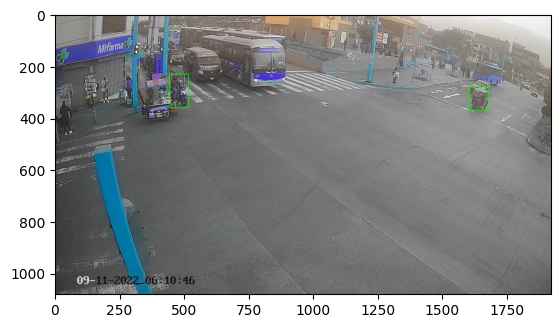

In [37]:
frame = cv2.imread("./data/FineTuned_YOLO/images/frame_030138.jpg").copy()
box = []
with open("./data/FineTuned_YOLO/labels/frame_030138.txt", "r") as f:
    for i in f:
        box.append(i.split())
print("box : class, x, y, w, h \n", box)
f.close()

for boxx in box:
    
    cl,x,y,w,h = [eval(i) for i in boxx]
    h_frame,w_frame,channel = frame.shape

    # top left
    xtl = int(x*w_frame-w*w_frame/2)
    ytl = int(y*h_frame+h*h_frame/2)

    # bottom right
    xbr = int(x*w_frame+w*w_frame/2)
    ybr = int(y*h_frame-h*h_frame/2)

    frame = cv2.rectangle(frame, (xtl,ytl),(xbr,ybr),(0,255,0),2 )

plt.imshow(frame)
plt.show()

### Create: train, valid and test .txt

In [10]:
labels = os.listdir("./data/FineTuned_YOLO/labels")
train_labels = labels[0:int((len(labels) * 70)/100)]
val_labels = labels[int((len(labels) * 70)/100):int((len(labels) * 90)/100)]
test_labels = labels[int((len(labels) * 90)/100):]

In [14]:
print("total : ", len(labels))
print("train : ", len(train_labels))
print("test  : ", len(test_labels))
print("val   : ", len(val_labels))

total :  169
train :  118
test  :  17
val   :  34


In [36]:
# copy images to train, val and test folders
for label in train_labels:
    filename = label.split(".")[0]
    path = os.getcwd()
    # images source and destination path
    img_src = path +'/data/FineTuned_YOLO/images/'+filename+'.jpg'
    img_dst = path +'/data/FineTuned_YOLO/Train/images/'+filename+'.jpg'
    # labels source and destination path
    label_src = path + '/data/FineTuned_YOLO/labels/'+filename+'.txt'
    label_dst = path + '/data/FineTuned_YOLO/Train/labels/'+filename+'.txt'
    
    shutil.copy(img_src, img_dst)
    shutil.copy(label_src, label_dst)

for label in val_labels:
    filename = label.split(".")[0]
    path = os.getcwd()
    # images source and destination path
    img_src = path +'/data/FineTuned_YOLO/images/'+filename+'.jpg'
    img_dst = path +'/data/FineTuned_YOLO/Val/images/'+filename+'.jpg'
    # labels source and destination path
    label_src = path + '/data/FineTuned_YOLO/labels/'+filename+'.txt'
    label_dst = path + '/data/FineTuned_YOLO/Val/labels/'+filename+'.txt'
    
    shutil.copy(img_src, img_dst)
    shutil.copy(label_src, label_dst)

for label in test_labels:
    filename = label.split(".")[0]
    path = os.getcwd()
    # images source and destination path
    img_src = path +'/data/FineTuned_YOLO/images/'+filename+'.jpg'
    img_dst = path +'/data/FineTuned_YOLO/Test/images/'+filename+'.jpg'
    # labels source and destination path
    label_src = path + '/data/FineTuned_YOLO/labels/'+filename+'.txt'
    label_dst = path + '/data/FineTuned_YOLO/Test/labels/'+filename+'.txt'
    
    shutil.copy(img_src, img_dst)
    shutil.copy(label_src, label_dst)

## Train YOLO

In [37]:
# train yolov7
!ls

data  FineTunning-YOLO.ipynb  merge_data_video1.ipynb  README.md  yolov7


In [38]:
%cd yolov7

/home/angel/Documents/galois1915/Aforo-vehicular/yolov7


/home/angel/Documents/galois1915/Aforo-vehicular/.env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [39]:
!ls

cfg	   hubconf.py	   paper	     test.py	      video1_test.mp4
data	   inference	   __pycache__	     tools	      yolov7-e6e.pt
deploy	   LICENSE.md	   README.md	     traced_model.pt  yolov7-tiny.pt
detect.py  man_cafe.jpg    requirements.txt  train_aux.py
export.py  man_cafe.jpg.1  runs		     train.py
figure	   models	   scripts	     utils


### Train all

In [ ]:
!python train.py --batch-size 10 --data "../data/FineTuned_YOLO/data.yaml" --img 1080 1920 --weight "./yolov7-tiny.pt" --name yolov7-custom --epoch 10
!python detect.py --weights "./runs/train/yolov7-custom9/weights/best.pt" --conf 0.25 --source ./video1_test.mp4

### With freeze layer

In [ ]:
!python train.py --freeze 29 --batch-size 10 --data "../data/FineTuned_YOLO/data.yaml" --img 1080 1920 --weight "./yolov7-tiny.pt" --name yolov7-custom-freeze --epoch 10
!python detect.py --weights "./runs/train/yolov7-custom-freeze/weights/best.pt" --conf 0.25 --source ./video1_test.mp4

with <code>--hyp data/hyp.scratch.tiny.yaml</code>

In [ ]:
!python train.py --freeze 29 --batch-size 20 --data "../data/FineTuned_YOLO/data.yaml" --img 1080 1920 --weight "./yolov7-tiny.pt" --name yolov7-custom-freezeee --hyp data/hyp.scratch.tiny.yaml --epoch 10
!python detect.py --weights "./runs/train/yolov7-custom-freezeee/weights/best.pt" --conf 0.25 --source ./video1_test.mp4